In [12]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young


<hr style="height:2pt">

In [13]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<div style = "background: maroon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

In [14]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit

In [15]:
# measure notebook runtime
time_start = time.time()

## Notebook Contents
<a id="contents"></a>
- **Dataset Information**
- **Bayesian Logistic Regression with Varying-Intercept Description**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


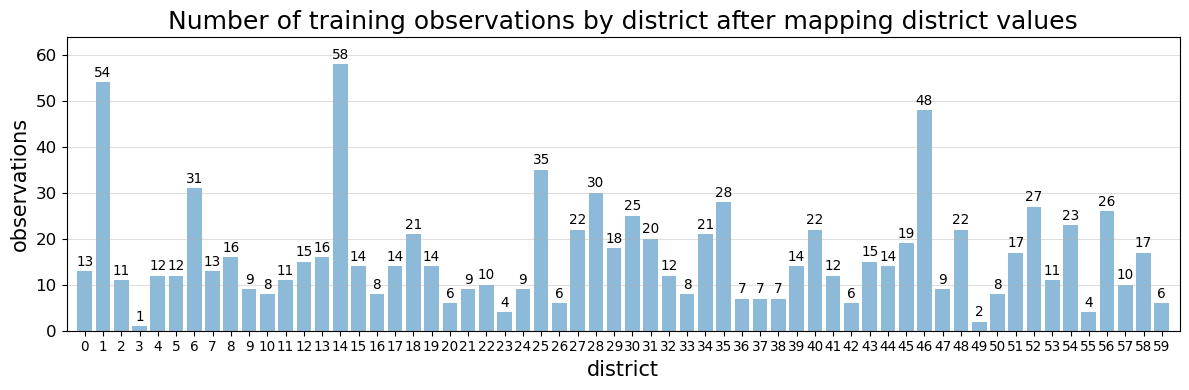

In [16]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        )

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 46% to 49% of subjects use contraceptives.**

In [17]:
# set seed for consistency across runs
np.random.seed(109)

# total observations and clusters
N = 967
J = 60

# generating B0 for each district
mu_0 = 2
sigma_0 = np.sqrt(1)
beta_0j = np.random.normal(mu_0, sigma_0, J)
df_train['beta_0j'] = df_train['district'].apply(lambda x: beta_0j[x - 1])

# specify all betas
beta_1 = 4
beta_2 = -3
beta_3 = -2

# calculate probability
df_train['logit_p'] = df_train['beta_0j'] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']
df_train['p'] = 1 / (1 + np.exp(-df_train['logit_p']))

simulated_Y = np.random.binomial(1, df_train['p'])

average_use = np.mean(simulated_Y)
print(average_use)

#For Q1.4
sim_beta_0j = beta_0j

0.4756980351602896


In [18]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [19]:
# your code here

with pm.Model() as varying_intercept_model:
    # prior
    mu_0 = pm.Normal('mu_0', mu=0, sigma=10000)
    sigma_0 = pm.InverseGamma('sigma_0', alpha=0.1, beta=0.1)

    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma=sigma_0, shape=J)

    beta_1 = pm.Normal('beta_1', mu=0, sigma=10000)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10000)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=10000)

    logit_p = beta_0j[df_train['district'] - 1] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']

    # likelihood or sampling distribution of observations
    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.sigmoid(logit_p), observed=simulated_Y)

    # MCMC settings and model fitting
    trace = pm.sample(2000, tune=1000, target_accept=0.99)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_0, sigma_0, beta_0j, beta_1, beta_2, beta_3]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 436 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

The r_hat values show that the samplers do not seem to have converged. 95% of the samples have r_hat values above the heuristic threshold of 1.1, with more than half being above 1.31. This indicates poor convergance and that we might need to run more iterations. The density plots also confirm poor convergence since they are not overlapping cleanly. The trace plots also are not converging into a fuzzy caterpillar. The plots for $\beta_1$ and $\beta_3$ are closest to indicating some convergence, but only one sample from each parameter had an r_hat value below 1.1. These parameters seem relatively closest to convergence.

In [20]:
summary_df = pm.summary(trace)
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,1.336,0.801,-0.083,2.783,0.452,0.355,3.0,16.0,1.65
beta_0j[0],1.279,0.866,-0.224,2.827,0.460,0.357,4.0,26.0,1.49
beta_0j[1],1.355,0.880,-0.359,2.742,0.453,0.349,4.0,27.0,1.46
beta_0j[2],1.393,0.923,-0.239,3.061,0.465,0.357,4.0,40.0,1.44
beta_0j[3],1.331,0.886,-0.260,2.825,0.469,0.364,4.0,34.0,1.51
...,...,...,...,...,...,...,...,...,...
beta_0j[59],1.334,0.900,-0.263,2.884,0.455,0.349,4.0,24.0,1.44
beta_1,4.821,0.715,3.512,6.200,0.076,0.055,90.0,329.0,1.04
beta_2,-2.969,0.359,-3.615,-2.307,0.159,0.121,5.0,25.0,1.31
beta_3,-2.128,0.205,-2.447,-1.745,0.014,0.010,191.0,494.0,1.01


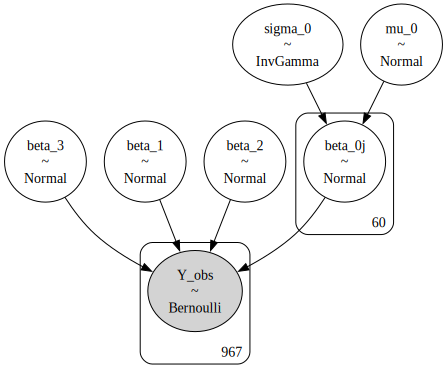

In [21]:
pm.model_to_graphviz(varying_intercept_model)

In [22]:
#SHARE WITH R_HAT <= 1.1 (GOOD)

summary_df[(summary_df['r_hat'] <= 1.1)]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_1,4.821,0.715,3.512,6.200,0.076,0.055,90.0,329.0,1.04
beta_3,-2.128,0.205,-2.447,-1.745,0.014,0.010,191.0,494.0,1.01
sigma_0,0.311,0.237,0.023,0.742,0.040,0.029,25.0,30.0,1.07


In [23]:
#SHARE WITH R_HAT > 1.1 (CAUSE FOR CONCERN)

summary_df[(summary_df['r_hat'] > 1.1)].shape[0]/len(summary_df)


0.9538461538461539

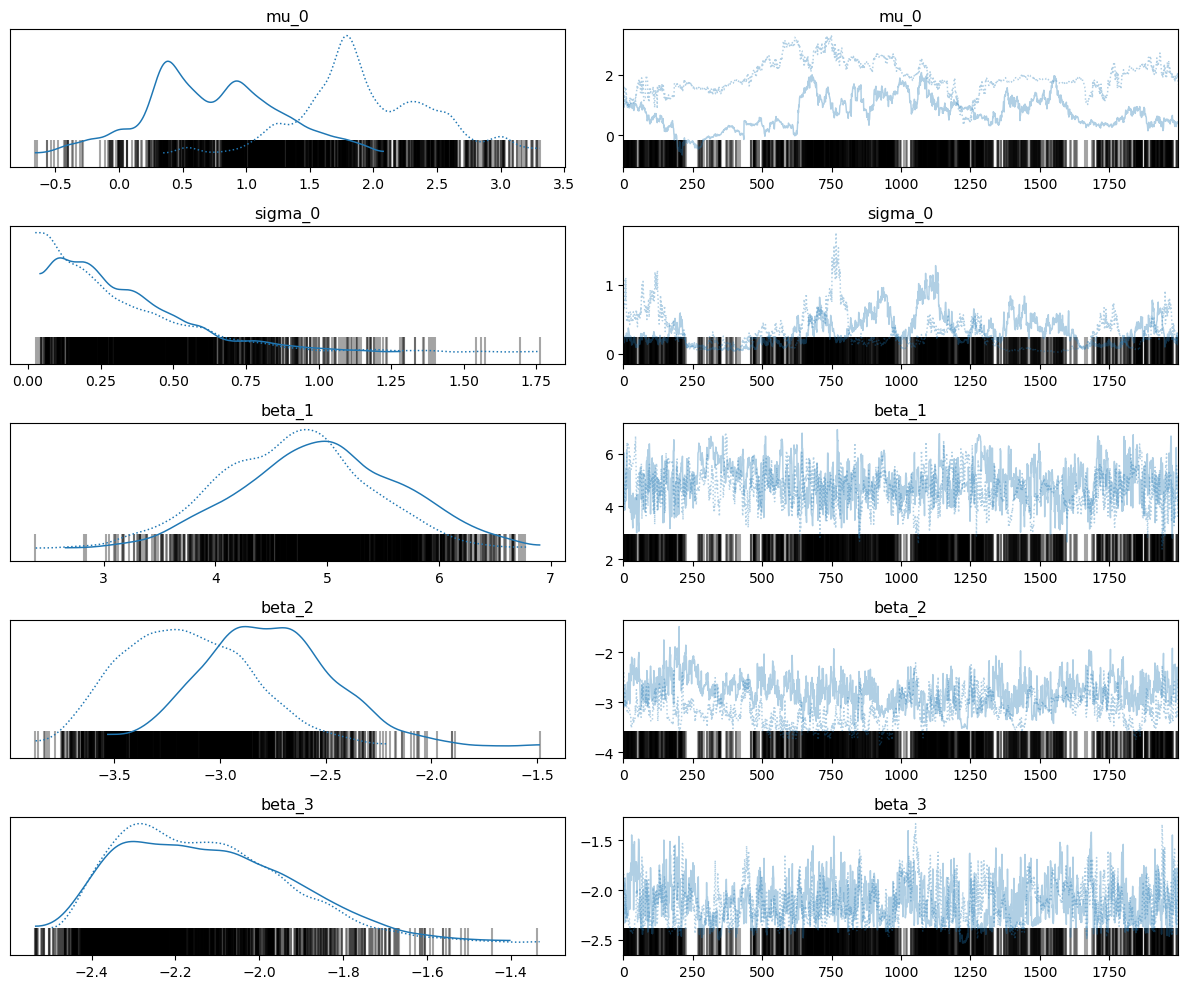

In [24]:
with varying_intercept_model:
    az.plot_trace(trace, var_names=['mu_0', 'sigma_0', 'beta_1', 'beta_2', 'beta_3'])
    plt.tight_layout();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

Comparing the posterior distribution to the $\beta_{0j}$ from the simulated data above, we can see that the values are contained in the posterior distribution. The true values of beta_0j from the simulated data fall within the 94% Highest Density Interval (HDI) of the posterior distributions, suggesting that the model is capturing the true parameter values well within its uncertainty. For some districts, the model's estimates are centered around the true values which is good. However, it is also important to note that HDI is quite wide for all districts and that there is high uncertainty in the posterior estimates.

In [25]:
[sim_beta_0j[8], sim_beta_0j[18], sim_beta_0j[28], sim_beta_0j[38], sim_beta_0j[48], sim_beta_0j[58]]


[1.8223119818656208,
 1.8738557308902266,
 2.7181965759638875,
 2.103770036193457,
 1.5276531890545448,
 1.6457892312469375]

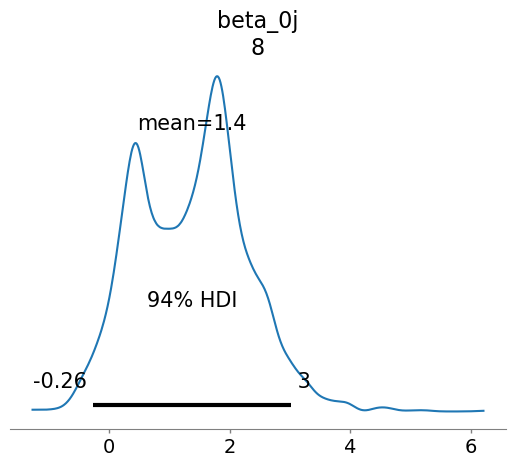

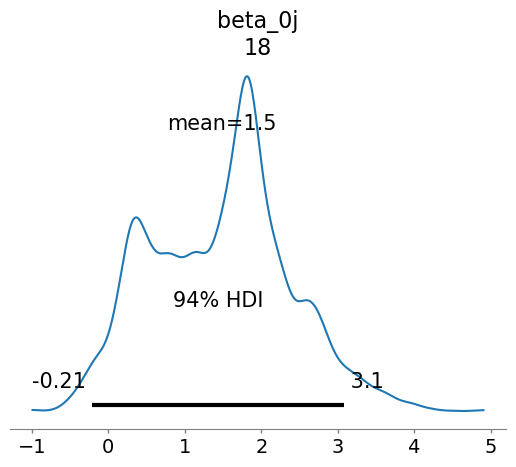

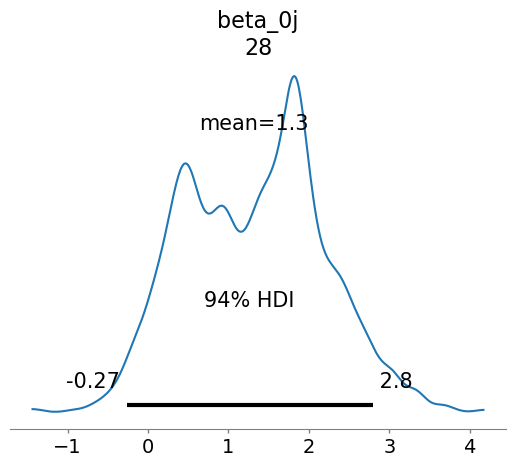

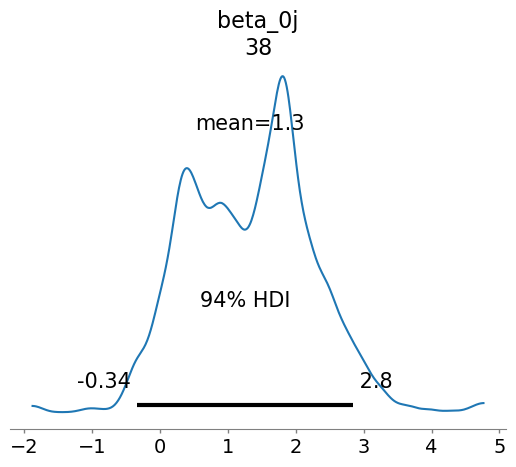

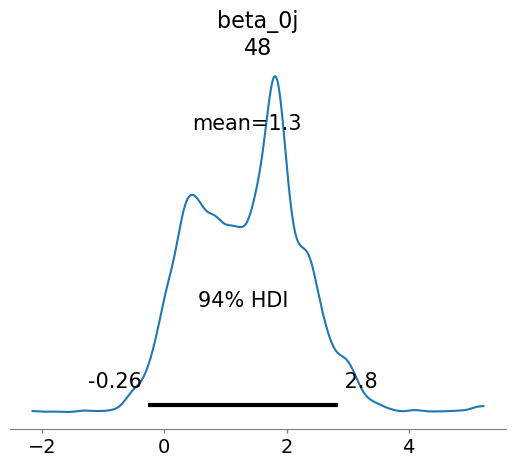

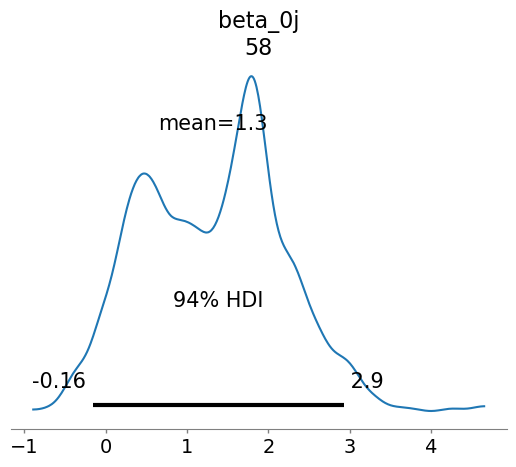

In [26]:
# because of 0 index
indices = [8, 18, 28, 38, 48, 58]

# plot posterior
for idx in indices:
    az.plot_posterior(trace, var_names=['beta_0j'], coords={'beta_0j_dim_0': [idx]})

<!-- END QUESTION -->

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [27]:
# your code here

N = len(df_train)
J = df_train['district'].nunique()

with pm.Model() as real_data_model:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=10000)
    sigma_0 = pm.InverseGamma('sigma_0', alpha=0.1, beta=0.1)

    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma=sigma_0, shape=J)

    beta_1 = pm.Normal('beta_1', mu=0, sigma=10000)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=10000)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=10000)

    logit_p = beta_0j[df_train['district'].values - 1] + beta_1 * df_train['urban'] + beta_2 * df_train['living.children'] + beta_3 * df_train['age_mean']

    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.sigmoid(logit_p), observed=df_train['contraceptive_use'])

    trace_var_int = pm.sample(2000, tune=1000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_0, sigma_0, beta_0j, beta_1, beta_2, beta_3]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 278 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

We see much better results indicating good convergence with the varying intercept model on the actual data. The highest r_hat value is 1.01 which is very close to 1, and the density plots show that the density of the samples for each parameter have good overlap. The trace plots have the fuzzy caterpillar look with tight similar movements across the samples. 

In [28]:
#Describe r_hat and see that even the max value is well within 1.1
summary = pm.summary(trace_var_int)
summary.r_hat.describe()


count    65.000000
mean      1.000769
std       0.002685
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.010000
Name: r_hat, dtype: float64

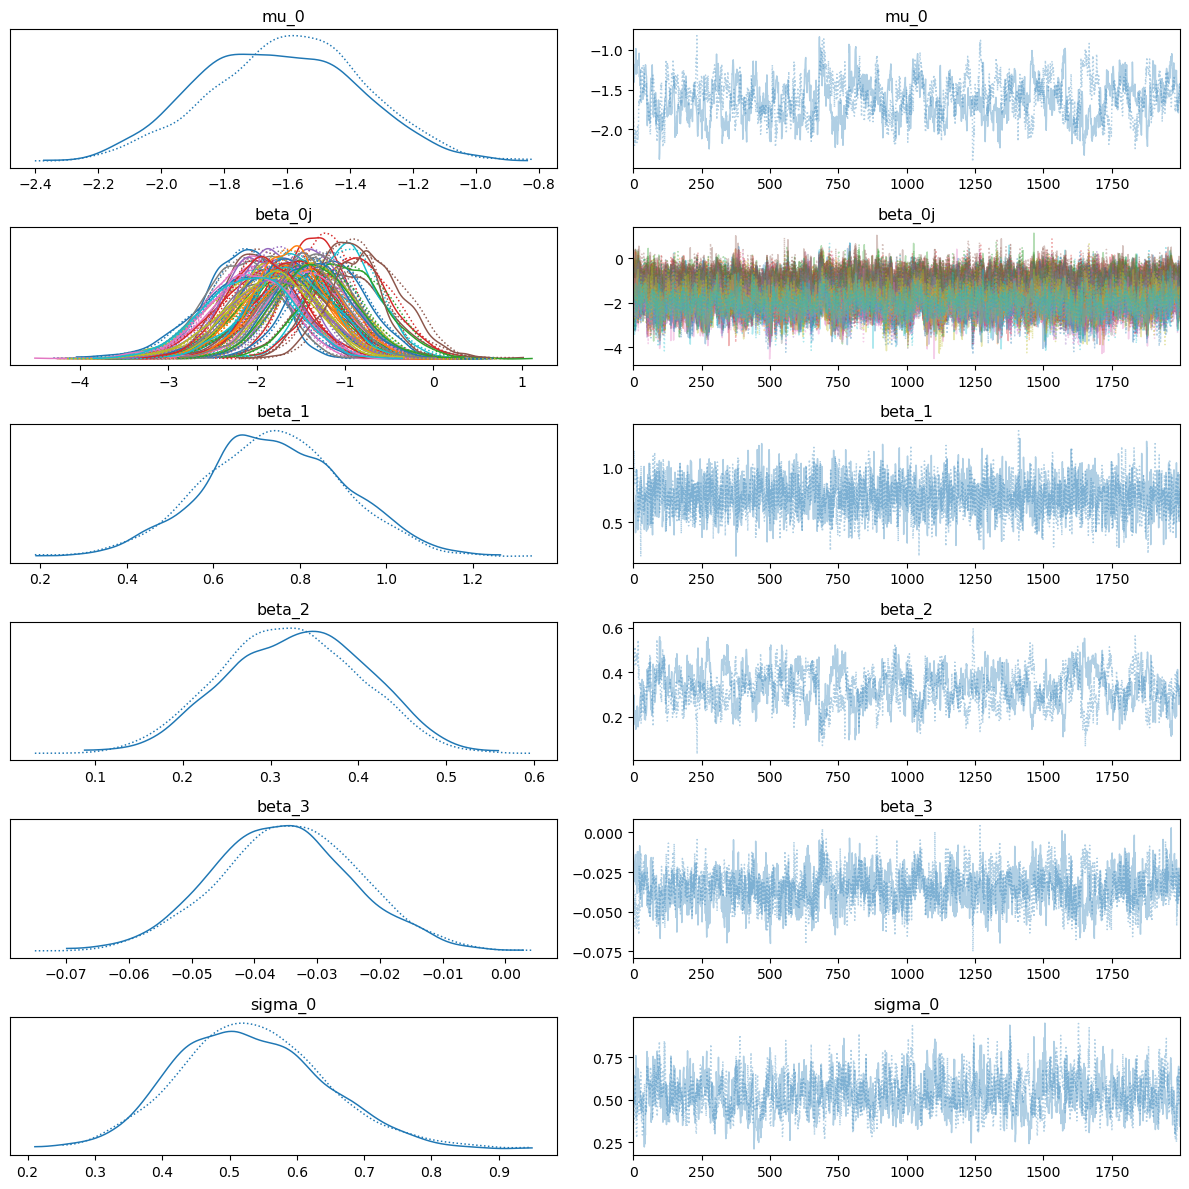

In [29]:
# your code here

az.plot_trace(trace_var_int)
plt.tight_layout();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

District 56 has the highest base rate of contraceptive usage and district 11 has the lowest base rate of contraceptive usage. I used the minimum and maximum $\beta_0$ value across the districts to find the lowest and highest base rate, respectively. The $\beta_0$ coefficient for each district will give the baseline value without looking at the effect of the other covariates in our data. We also added a 1 for each value since the index for district starts at 0.

In [30]:
districts_beta_0j_means = summary.loc[summary.index.str.contains('beta_0j'), 'mean']

In [31]:
print('District {} has the highest base rate of contraceptive usage'.format(np.argmax(districts_beta_0j_means)+1))
print('District {} has the lowest base rate of contraceptive usage'.format(np.argmin(districts_beta_0j_means)+1))


District 56 has the highest base rate of contraceptive usage
District 11 has the lowest base rate of contraceptive usage


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

The posterior means of $\mu_0$ and $\sigma_0$ are -1.6 and 0.53, respectively. We also know that the 94% HDI for $\mu_0$ is [-2.1,-1.1] so we are confident that the intercept is in this range and statistically different from 0. The mean $\sigma_0$ shows that there is a 0.53 standard deviation difference in intercepts by district. The positive range for the 94% HDI shows that this is a statistically significant difference. These mean values provide strong support for the appropriateness of the varying-intercept model in this case since we determined that the intercepts for each district are different.

array([<Axes: title={'center': 'mu_0'}>,
       <Axes: title={'center': 'sigma_0'}>], dtype=object)

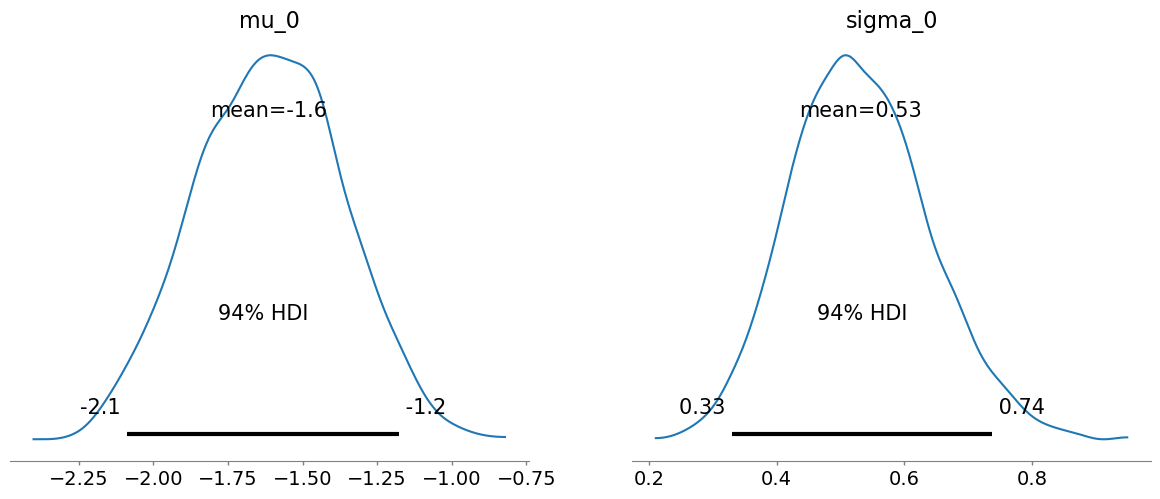

In [32]:
# your code here
az.plot_posterior(trace_var_int, var_names=['mu_0', 'sigma_0'])

In [33]:
summary = az.summary(trace_var_int, var_names=['mu_0', 'sigma_0'])
print(summary)

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0    -1.612  0.246  -2.089   -1.176      0.017    0.012     210.0   
sigma_0  0.532  0.109   0.330    0.738      0.005    0.003     521.0   

         ess_tail  r_hat  
mu_0        533.0   1.01  
sigma_0    1135.0   1.00  


<!-- END QUESTION -->

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [34]:
# your code here
n_districts = df_train['district'].nunique()
district_idx = df_train['district'].values

with pm.Model() as varying_coefficients_model:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=np.sqrt(10000))
    sigma_0 = pm.Gamma('sigma_0', alpha=0.1, beta=0.1)

# vary coefficients
    beta_0 = pm.Normal('beta_0', mu=mu_0, sigma=sigma_0, shape=n_districts)
    sigma_1 = pm.Gamma('sigma_1', alpha=0.1, beta=0.1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=sigma_1, shape=n_districts)
    sigma_2 = pm.Gamma('sigma_2', alpha=0.1, beta=0.1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=sigma_2, shape=n_districts)
    sigma_3 = pm.Gamma('sigma_3', alpha=0.1, beta=0.1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=sigma_3, shape=n_districts)

    logits = beta_0[district_idx] + beta_1[district_idx] * df_train['urban'] + beta_2[district_idx] * df_train['living.children'] + beta_3[district_idx] * df_train['age_mean']

    Y_obs = pm.Bernoulli('Y_obs', pm.math.sigmoid(logits), observed=df_train['contraceptive_use'])

    trace_coef_var = pm.sample(1000, tune=1000, target_accept=0.99)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_0, sigma_0, beta_0, sigma_1, beta_1, sigma_2, beta_2, sigma_3, beta_3]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 667 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

The r_hat values now show that the samplers do not seem to have converged. 64% of the samples have r_hat values above the heuristic threshold of 1.1, with more than 43% being above 1.31. This shows poor convergence of the samplers, and that the model might need to run more iterations. The density plots also confirm poor convergence since we are seeing different distribution shapes and not clean overlap for all of the parameters. $\beta_0$ values for a specific district do not seem to match. About 35% of the samples have r_hat of 1.1 or less, so we do see some parameters that are closer to convergence (mu_0 and the beta values), but this is not the case for the sigma parameters. 


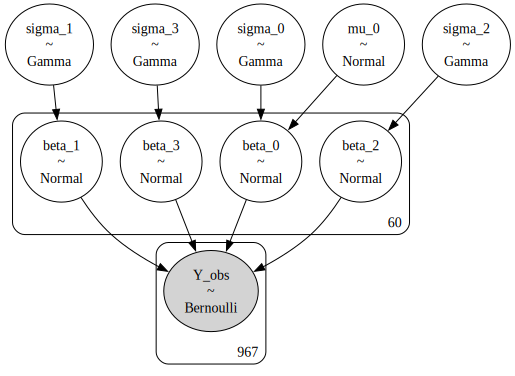

In [35]:
# your code here
# your code here
pm.model_to_graphviz(varying_coefficients_model)

In [ ]:
az.plot_trace(trace_coef_var)

In [36]:
summary_q3 = az.summary(trace_coef_var)
summary_q3.r_hat.describe()


count    245.000000
mean       1.024571
std        0.025292
min        1.000000
25%        1.000000
50%        1.020000
75%        1.040000
max        1.130000
Name: r_hat, dtype: float64

In [37]:
#SHARE WITH R_HAT <= 1.1 (GOOD)
round(summary_q3[(summary_q3['r_hat'] <= 1.1)].shape[0]/len(summary_q3),3)


0.996

In [38]:
#SHARE WITH R_HAT > 1.1 (CAUSE FOR CONCERN)

round(summary_q3[(summary_q3['r_hat'] > 1.1)].shape[0]/len(summary_q3),3)


0.004

In [39]:
#SHARE WITH R_HAT > 1.3 (WE HAVE PROBLEMS)
round(summary_q3[(summary_q3['r_hat'] > 1.3)].shape[0]/len(summary_q3),3)


0.0

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

We can see from this forest plot that we have varying $\beta_0$  and $\beta_1$, but not varying $\beta_2$ and $\beta_3$ The variance in the $\beta_0$ values indicates that there are baseline differences in contraceptive use by districts, and that the variance in $\beta_1$ shows that the effect of urban/rural on contraceptive use differs by district. Mean age and number of living children do not seem to have as much variation across districts, indicating that a coefficient varying model may not be suited to this data.

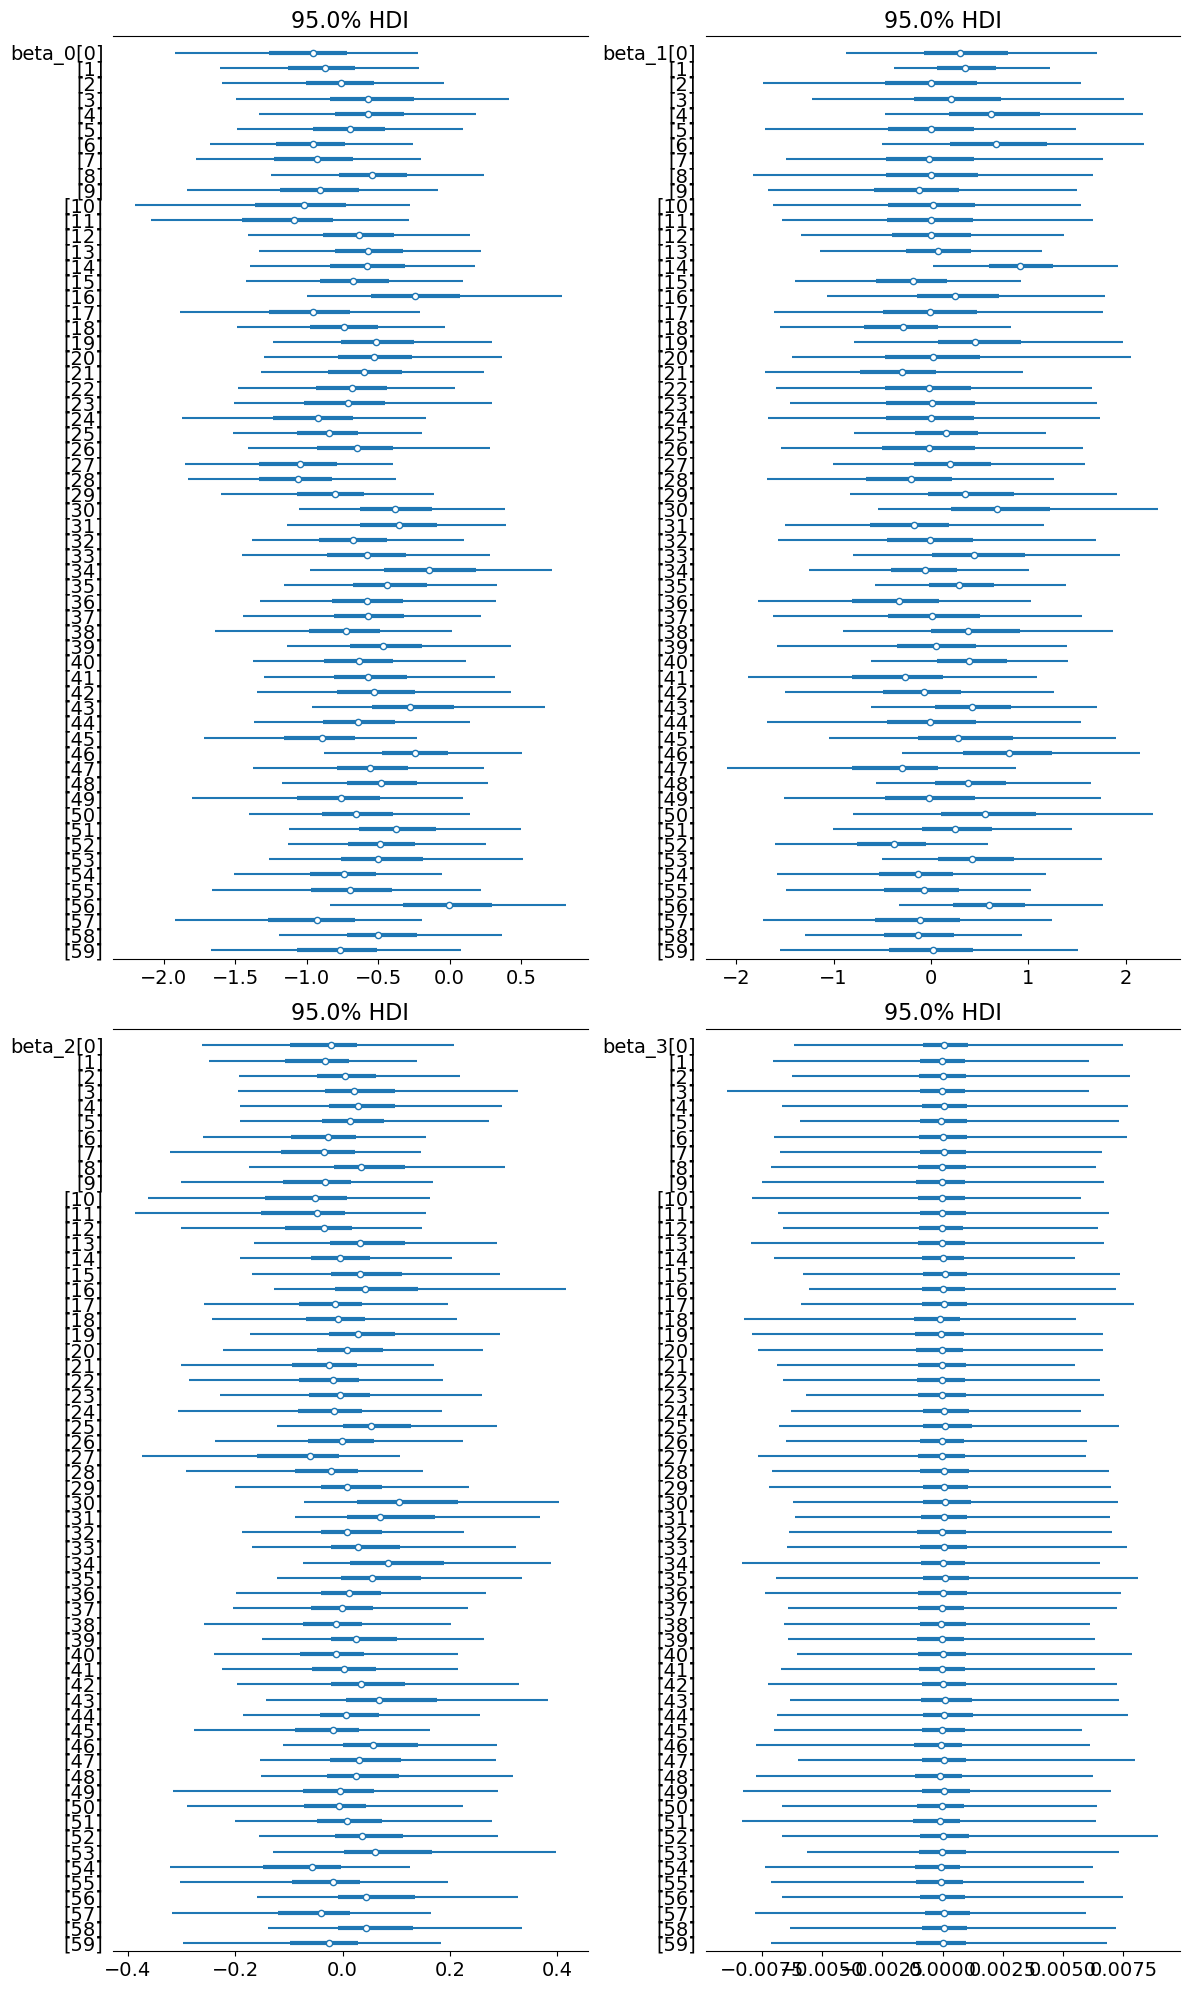

In [40]:
# your code here
fig, axs = plt.subplots(2, 2, figsize=(12, 20))

az.plot_forest(trace_coef_var, var_names=['beta_0'], combined=True, ax=axs[0, 0], hdi_prob=0.95)
az.plot_forest(trace_coef_var, var_names=['beta_1'], combined=True, ax=axs[0, 1], hdi_prob=0.95)
az.plot_forest(trace_coef_var, var_names=['beta_2'], combined=True, ax=axs[1, 0], hdi_prob=0.95)
az.plot_forest(trace_coef_var, var_names=['beta_3'], combined=True, ax=axs[1, 1], hdi_prob=0.95)

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Create and Evaluate Classifiers</b></div>

Build two Bayesian logistic regression classifiers: one from your varying-intercept model (Q2) and another from your varying-coefficients model (Q3). Then, use each model to make predictions on your training and test sets.

* For each of the two classifiers, **on both train and test data separately**, report:
    * percentage of observations predicted to be `1` (i.e., uses contraceptives)
    * accuracy score

Finally, briefly describe the approach you used to implement these classifiers.
  
**Hint:** These classification models will make use of the samples generated by your PyMC models above, but they need not themselves be PyMC model objects. They can also be constructed out of simple Python functions of your own design.

The approach is as follows: 

1. Fit a Bayesian Model: We used a varying-intercept logit regression model to train our data to capture the uncertainty in the model parameters. This step was done earlier.  

2.  ⁠⁠Conduct Posterior Predictive Sampling: We then generate predicted probabilities for both training and test datasets using the posterior distribution of the model's parameters to simulate possible outcomes

3. ⁠⁠Classification: We also transform the predicted probabilities into binary classifications using a threshold of 0.5. If the predicted probability for an observation was greater than 0.5, it was classified as '1' (uses contraceptives); otherwise, it was classified as '0' (does not use contraceptives).

4. ⁠⁠Evaluate Performance: We also evaluate model accuracy by comparing the predicted classifications to the actual data for both the train and test datasets

In [ ]:
#USE THE VARYING COEFFICIENTS MODEL TO CREATE A BAYESIAN LOGISTIC REGRESSION CLASSIFIER (TRAIN)
with varying_coefficients_model:
    ppc = pm.sample_posterior_predictive(trace_coef_var)
    train_pred_prob = ppc.posterior_predictive['Y_obs'].values.mean(axis=0)
    train_predictions = (train_pred_prob > 0.5).astype(int)
    train_share_ones = np.mean(train_predictions) * 100
    train_accuracy = np.mean(train_predictions == df_train['contraceptive_use'].values) * 100

print(f"Varying Coefficients Model - Training data: {train_share_ones:.2f}% predicted to use contraceptives with an accuracy of {train_accuracy:.2f}%")

n_districts_test = df_test['district'].nunique()
district_idx_test = df_test['district'].values

#USE THE VARYING COEFFICIENTS MODEL TO CREATE A BAYESIAN LOGISTIC REGRESSION CLASSIFIER (TEST)
with varying_coefficients_model:
    ppc_test = pm.sample_posterior_predictive(trace_coef_var)
    test_pred_prob = ppc.posterior_predictive['Y_obs'].values.mean(axis=0)
    test_predictions = (test_pred_prob > 0.5).astype(int)
    test_share_ones = np.mean(test_predictions) * 100
    test_accuracy = np.mean(test_predictions == df_test['contraceptive_use'].values) * 100

print(f"Varying Coefficients Model - Test data: {test_share_ones:.2f}% predicted to use contraceptives with an accuracy of {test_accuracy:.2f}%")


In [ ]:
#USE THE VARYING INTERCEPT MODEL TO CREATE A BAYESIAN LOGISTIC REGRESSION CLASSIFIER (TRAIN)

with varying_intercept_model:
    ppc = pm.sample_posterior_predictive(trace_var_int)
    train_pred_prob = ppc.posterior_predictive['Y_obs'].values.mean(axis=0)
    train_predictions = (train_pred_prob > 0.5).astype(int)
    train_share_ones = np.mean(train_predictions) * 100
    train_accuracy = np.mean(train_predictions == df_train['contraceptive_use'].values) * 100

print(f"Varying Intercept Model - Training data: {train_share_ones:.2f}% predicted to use contraceptives with an accuracy of {train_accuracy:.2f}%")

#USE THE VARYING INTERCEPTS MODEL TO CREATE A BAYESIAN LOGISTIC REGRESSION CLASSIFIER (TEST)
with varying_intercept_model:
    ppc_test = pm.sample_posterior_predictive(trace_var_int)
    test_pred_prob = ppc.posterior_predictive['Y_obs'].values.mean(axis=0)
    test_predictions = (test_pred_prob > 0.5).astype(int)
    test_share_ones = np.mean(test_predictions) * 100
    test_accuracy = np.mean(test_predictions == df_test['contraceptive_use'].values) * 100

print(f"Varying Intercept Model - Test data: {test_share_ones:.2f}% predicted to use contraceptives with an accuracy of {test_accuracy:.2f}%")


In [ ]:
#Check bias in outcome
df_test['contraceptive_use'].value_counts()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Comparison to Naive Model</b></div>

Report the same four metrics from the previous question for a 3rd, "naive" model that always predicts the most frequent outcome observed in the training data.

In [ ]:
freq_y_obs = df_train['contraceptive_use'].mode()[0]

#TRAIN
train_naive_preds = np.full_like(df_train['contraceptive_use'], fill_value=freq_y_obs)
# Calculate share of 1s and accuracy in train data
train_naive_share_ones = np.mean(train_naive_preds) * 100
train_naive_accuracy = np.mean(train_naive_preds == df_train['contraceptive_use']) * 100

#TEST
test_naive_preds = np.full_like(df_test['contraceptive_use'], fill_value=freq_y_obs)
# Calculate share of 1s and accuracy in test data
test_naive_share_ones = np.mean(test_naive_preds) * 100
test_naive_accuracy = np.mean(test_naive_preds == df_test['contraceptive_use']) * 100

print(f"Naive model predictions for training data: {train_naive_share_ones:.2f}% predicted to use contraceptives with an accuracy of {train_naive_accuracy:.2f}%")
print(f"Naive model predictions for test data: {test_naive_share_ones:.2f}% predicted to use contraceptives with an accuracy of {test_naive_accuracy:.2f}%")


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 - Model Selection</b></div>

What do you conclude from the results of 4.1 & 4.2? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

Based on the test accuracy as well as the simplicity, I would argue that the naive model would be the best in this case. The test case accuracy was 56.24% for the coef-varying model, 55.85% for the intercept-varying model and 60.5% for the naive model. The naive classifier is not only more accurate on the test data, it is much more simple and interpretable. Since there is a skew in contraception adoption (smaller share adopting), predicting the class that appears most in the dataset ends up giving the best outcome. Our logistic regression  relied on a small number of other covariates, which may not be capturing a lot of the information requried to make more accurate predictions for contraception use. 

We know that there was some variation in contraception use by district for example, and the results from the varying-intercept and varying-coefficient model do have slightly higher train accuracy than the naive model, but there is a drop in test accuracy for those complex models indicating overfitting. Applying the sampling method on data will usually need to be done with few parameters since it's quite computationally expensive. This could be an issue when the available parameters cannot explain enough of the variation in the outcome to serve as good predictors, as demonstrated in this example. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

The homework was very helpful solidifying the concepts we learned over the course of the Bayesian statistics lectures. I think one aspect that got a bit confusing was the lack of grade checkers as guidelines to make sure that we were on track. Conceptually, we found that the assignment was clear and well scoped. 

In [ ]:
time_spent_on_hw = 5

In [ ]:
grader.check("q4.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW2. Thank you!**